### Objectif
Prediction de possibilité de re-payer  un emprunt . 
<hr />

<p style="border:1px solid #85c1e9;border-radius:5px;padding:1em;width:100%;background:#85c1e9;font-size:1.6em;text-align:center;">0-Librairies et premières observations</p>

In [44]:
# usual data science stack in python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# imports of need modules in sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# load main datasets
app_train, app_test = pd.read_csv("./data/application_train.csv"), pd.read_csv("./data/application_test.csv")

In [3]:
display(app_train.head(3))
display(app_test.head(3))

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


In [4]:
app_train.shape, app_test.shape

((307511, 122), (48744, 121))

<p style="border:1px solid #85c1e9;border-radius:5px;padding:1em;width:100%;background:#85c1e9;font-size:1.6em;text-align:center;">1-Analyse des données</p>

In [5]:
app_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [6]:
print("Pourcentage de clients en difficultés de payments:",app_train.TARGET.sum() / app_train.shape[0] * 100 ,"%")

Pourcentage de clients en difficultés de payments: 8.072881945686495 %


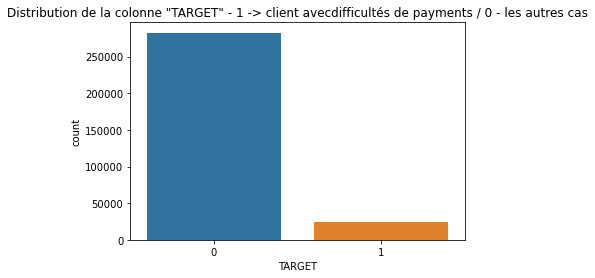

In [7]:
plt.title('Distribution de la colonne "TARGET" - 1 -> client avecdifficultés de payments / 0 - les autres cas')
sns.countplot(x=app_train.TARGET, data=app_train)
plt.show()

<div style="font-size:1.8em;"><span>&#10551;</span><span style="color:#E3893F;"> Nous voyons ici un probleme de <strong>classe non équilibré</strong>. En effet il y a plus de payment remboursésque que payments non remboursés.</span></div>


In [8]:
app_train.info()
print("----")
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [9]:
display(app_train.describe())
print("<---->")
display(app_test.describe())

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


<---->


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


In [10]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## les valeurs manquantes

In [11]:
# Function to calculate missing values by column# Funct // credits Will Koehrsen
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [12]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(12)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


## supression des colonnes avec un grand nombre de valeurs manquantes

In [14]:
# cols_to_drop = list((app_train.isnull().sum() > 75000).index)
cols_to_drop = [c for c in app_train.columns if app_train[c].isnull().sum() > 75000]
app_train, app_test = app_train.drop(cols_to_drop, axis=1), app_test.drop(cols_to_drop, axis=1)
app_test.isnull().sum().sort_values(ascending=False).head(10)

EXT_SOURCE_3                  8668
AMT_REQ_CREDIT_BUREAU_YEAR    6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_HOUR    6049
NAME_TYPE_SUITE                911
DEF_60_CNT_SOCIAL_CIRCLE        29
OBS_30_CNT_SOCIAL_CIRCLE        29
dtype: int64

### Colmater les valeurs manquantes

In [15]:
obj_cols = app_train.select_dtypes('object').columns
obj_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [16]:
# filling string cols with 'Not specified' 
app_train[obj_cols] = app_train[obj_cols].fillna('Not specified')
app_test[obj_cols] = app_test[obj_cols].fillna('Not specified')

In [17]:
float_cols = app_train.select_dtypes('float').columns
float_cols

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [19]:
# filling float values with median of train (not test)
app_train[float_cols] = app_train[float_cols].fillna(app_train[float_cols].median())
app_test[float_cols] = app_test[float_cols].fillna(app_test[float_cols].median())
app_train.shape, app_test.shape

((307511, 72), (48744, 71))

### Sur les colonnes categoriques

In [20]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

### Traitement des anomalies

In [21]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

<div style="font-size:1.1em;"><span>&#10551;</span><span style="color:#E3893F;"> La valeur maximale est anormal. Elle correspond a 1000 ans, c'est étrange</div>

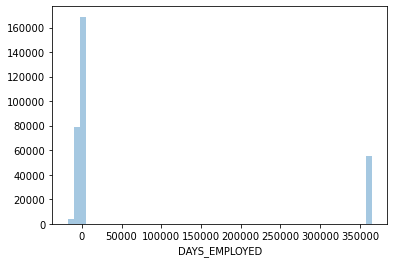

In [22]:
sns.distplot(app_train['DAYS_EMPLOYED'], kde=False);
plt.show()

In [23]:
print('The non-anomalies default on %0.2f%% of loans' % (100 * app_train[app_train['DAYS_EMPLOYED'] != 365243]['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * app_train[app_train['DAYS_EMPLOYED'] == 365243]['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(app_train[app_train['DAYS_EMPLOYED'] == 365243]))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


<div style="font-size:1.1em;"><span>&#10551;</span><span style="color:#E3893F;"> Il se trouve que les anomalies ont un plus bastaux de défaut Les valeurs anormales semblent avoir de l'importance. Nous allons donc remplir les valeurs anormales avec Nan et creer une colonne booléenne indiquant si la valeur est anormale ou non</div>

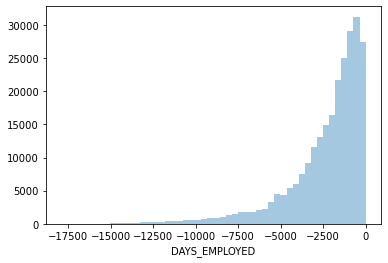

In [24]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

sns.distplot(app_train['DAYS_EMPLOYED'].dropna(), kde=False);

In [25]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [26]:
# refilling float values with median of train (not test)

app_train[float_cols] = app_train[float_cols].apply(pd.to_numeric, errors='coerce')
app_train = app_train.fillna(app_train.median())

app_test[float_cols] = app_test[float_cols].apply(pd.to_numeric, errors='coerce')
app_test = app_train.fillna(app_test.median())

### Correlations

<p>Le coeficient de corrélation n'est pas la méthode la plus adapté pour dire l'importance d'une feature, mais peut donner une idée des relations</p>

In [27]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(10))
print('\n\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.063368
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


Most Negative Correlations:
 EXT_SOURCE_2                 -0.160295
EXT_SOURCE_3                 -0.155892
DAYS_EMPLOYED_ANOM           -0.045987
AMT_GOODS_PRICE              -0.039623
REGION_POPULATION_RELATIVE   -0.037227
AMT_CREDIT                   -0.030369
FLAG_DOCUMENT_6              -0.028602
HOUR_APPR_PROCESS_START      -0.024166
FLAG_PHONE                   -0.023806
AMT_REQ_CREDIT_BUREAU_MON    -0.014794
Name: TARGET, dtype: float64


<AxesSubplot:>

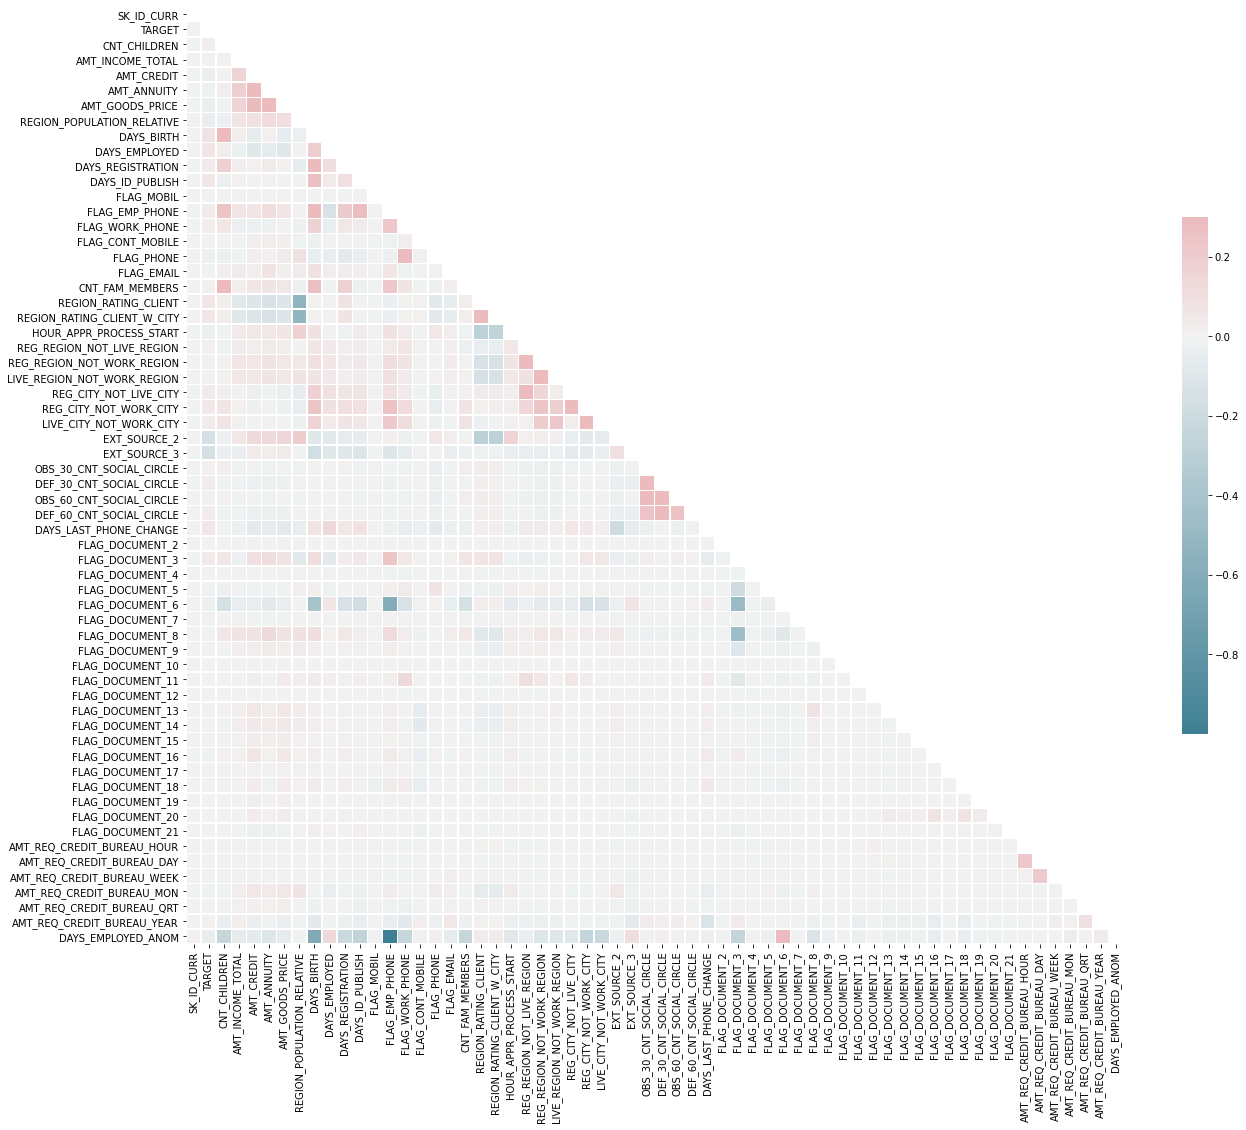

In [28]:
# Compute the correlation matrix
corr = app_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(21, 19))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### L'influence de l'Age sur le repayement du prêt

In [29]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830984513

<div style="font-size:1.1em;"><span>&#10551;</span><span style="color:#E3893F;"> Il n'y a aucune relation entre l'age et le repayment</div>

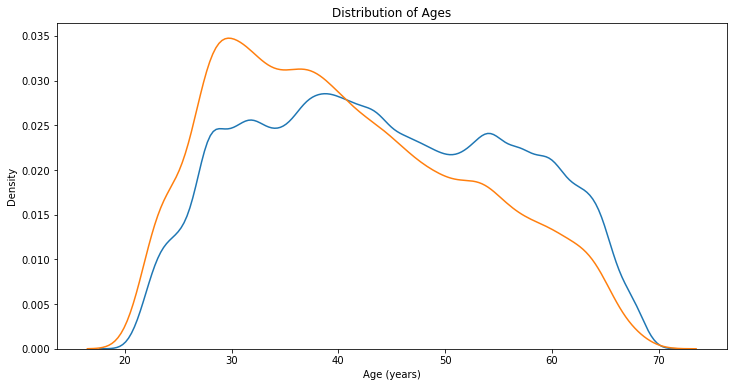

In [30]:
plt.figure(figsize = (12, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [31]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

C:\Users\malik\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\malik\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [32]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


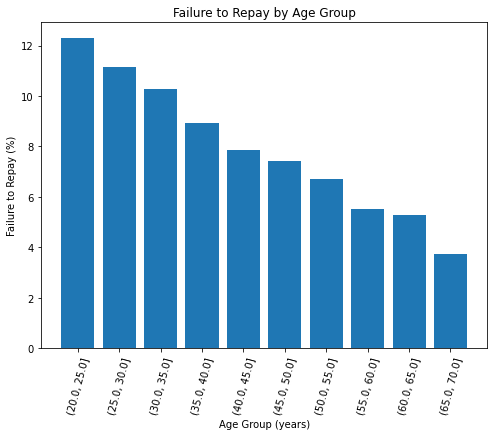

In [34]:
plt.figure(figsize = (8, 6))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

<div style="font-size:1.1em;"><span>&#10551;</span><span style="color:#E3893F;"> Les jeunes semblent plus âpte à repayer le prêt</div>

<p style="border:1px solid #85c1e9;border-radius:5px;padding:1em;width:100%;background:#85c1e9;font-size:1.6em;text-align:center;">2-Préparations des données</p>

### Encodages des varaibles catégoriques

In [35]:
app_train = pd.get_dummies(data=app_train, columns=obj_cols)
app_test = pd.get_dummies(data=app_test, columns=obj_cols)

### Alignement des datasets

In [36]:
# back up of the target /  need to keep this information
y = app_train.TARGET
app_train = app_train.drop(columns=['TARGET'])

In [39]:
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train.shape, app_test.shape

((307511, 168), (307511, 168))

### Mise à l'échelle des valeurs

In [40]:
feat_to_scale = list(float_cols).copy()
feat_to_scale.extend(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START'])
feat_to_scale

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CNT_CHILDREN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'HOUR_APPR_PROCESS_START']

In [41]:
scaler = StandardScaler()
app_train[feat_to_scale] = scaler.fit_transform(app_train[feat_to_scale])
app_test[feat_to_scale] = scaler.fit_transform(app_test[feat_to_scale])
app_train.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,-0.577538,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,-1.506880,0.755835,0.379837,...,0,0,0,0,0,0,0,0,0,0
1,100003,-0.577538,0.426792,1.725450,0.592683,1.600873,-1.252750,0.166821,0.497899,1.078697,...,0,0,0,0,0,0,0,0,0,0
2,100004,-0.577538,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,0.689509,0.948701,0.206116,...,0,0,0,0,0,0,0,0,0,0
3,100006,-0.577538,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,0.680114,-0.368597,-1.375829,...,0,0,0,0,0,0,0,0,0,0
4,100007,-0.577538,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,0.892535,-0.368129,0.191639,...,0,0,0,0,0,0,0,0,0,0


<p style="border:1px solid #85c1e9;border-radius:5px;padding:1em;width:100%;background:#85c1e9;font-size:1.6em;text-align:center;">3-Algorithme machine learning</p>

### Splitting training / test datasets

In [42]:
X_train, X_test, y_train, y_test = train_test_split(app_train, y, test_size=0.2)

###  Random Forest pas de cross validation

In [43]:
# a simple RandomForrest Classifier without CV
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [46]:
print("Roc auc score:", roc_auc_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred))

Roc auc score: 0.501017140783423
F1 score: 0.004471544715447154


<div style="font-size:1.1em;"><span>&#10551;</span><span style="color:#E3893F;">0.5.... pas un très bon résultats....</div>

###  Random Forest avec cross validation

In [47]:
rf_cv = RandomForestClassifier()
scores = cross_val_score(rf_cv, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

In [48]:
rf_cv.fit(X_train, y_train)
roc_auc_score(y_test, rf_cv.predict(X_test))

0.5001021033285685

## avec Hyperparametres
*    n_estimators = number of trees in the foreset
*    max_features = max number of features considered for splitting a node
*    max_depth = max number of levels in each decision tree
*    min_samples_split = min number of data points placed in a node before the node is split
*    min_samples_leaf = min number of data points allowed in a leaf node
*    bootstrap = method for sampling data points (with or without replacement)

In [50]:
# a simple RandomForrest Classifier without CV
rf = RandomForestClassifier(n_estimators=200,max_features='auto',max_depth=5,min_samples_split=10,min_samples_leaf=5,bootstrap='True')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Roc auc score:", roc_auc_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred))

Roc auc score: 0.5
F1 score: 0.0


### Features Importance

In [54]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(app_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 28 (0.229572)
2. feature 27 (0.222008)
3. feature 8 (0.073593)
4. feature 7 (0.048927)
5. feature 33 (0.033680)
6. feature 87 (0.029918)
7. feature 63 (0.029586)
8. feature 5 (0.028648)
9. feature 19 (0.024916)
10. feature 90 (0.021750)
11. feature 64 (0.021386)
12. feature 10 (0.020531)
13. feature 85 (0.018897)
14. feature 18 (0.018236)
15. feature 3 (0.014249)
16. feature 25 (0.013760)
17. feature 81 (0.012339)
18. feature 6 (0.012231)
19. feature 35 (0.012048)
20. feature 24 (0.010154)
21. feature 167 (0.008204)
22. feature 4 (0.007228)
23. feature 60 (0.006885)
24. feature 9 (0.006586)
25. feature 12 (0.006111)
26. feature 61 (0.005974)
27. feature 67 (0.004847)
28. feature 62 (0.004487)
29. feature 2 (0.004479)
30. feature 66 (0.004105)
31. feature 92 (0.003493)
32. feature 30 (0.003190)
33. feature 32 (0.002864)
34. feature 20 (0.002839)
35. feature 17 (0.002342)
36. feature 94 (0.002338)
37. feature 38 (0.001855)
38. feature 26 (0.001842)
39. feature

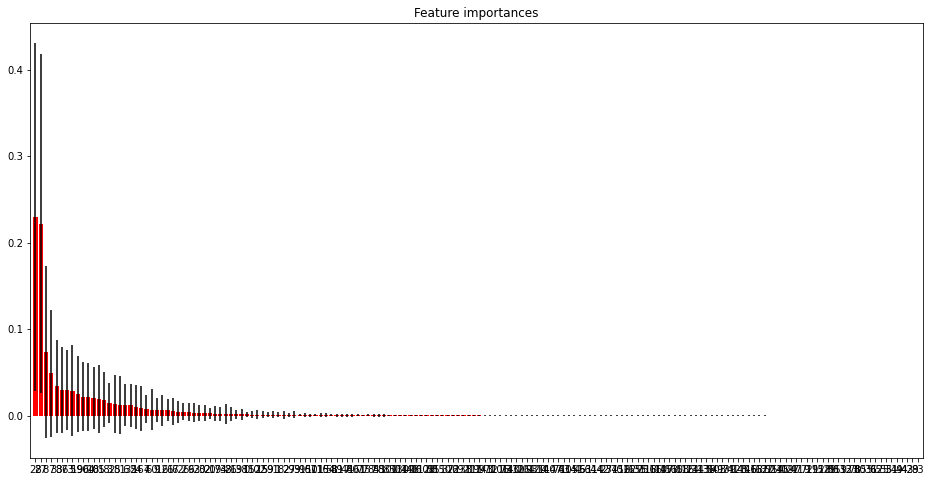

In [55]:
# Plot the feature importances of the rf
plt.figure(figsize=(16, 8))
plt.title("Feature importances")
plt.bar(range(app_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(app_train.shape[1]), indices)
plt.xlim([-1, app_train.shape[1]])
plt.show()

<AxesSubplot:>

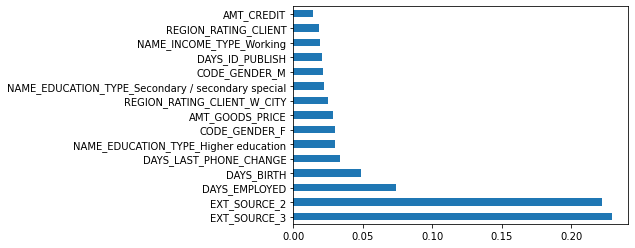

In [56]:
(pd.Series(rf.feature_importances_, index=app_train.columns)
   .nlargest(15)
   .plot(kind='barh'))

### LightGBM

In [52]:
lgbm = lgb.LGBMClassifier(random_state = 50)
lgbm.fit(X_train, y_train, eval_metric = 'auc')
print("Roc auc score:", roc_auc_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred))

Roc auc score: 0.5
F1 score: 0.0


### Avec hyperparameters et résultats:

*    underfitting / high biais -> let’s try to complified the model
*    max_depth = 7/11 or objective = ‘binary’ -> scores 0.508 / 0.508
*    n_estimators=1000 -> scores 0.57 / 0.511
*    class_weight = ‘balanced’ -> scores 0.71 / 0.68
*    reg_alpha = 0.1, reg_lambda = 0.1 -> no influence

In [53]:
lgbm = lgb.LGBMClassifier(random_state = 50, n_jobs = -1, class_weight = 'balanced')
lgbm.fit(X_train, y_train, eval_metric = 'auc')
roc_auc_score(y_train, lgbm.predict(X_train))

0.7113483416449252

<div style="font-size:1.1em;"><span>&#10551;</span><span style="color:#E3893F;">0.7.... de bien meilleurs résultats....</div>

## Avec XGBOOST

In [57]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=50, eval_metric='auc', 
                              max_delta_step=2, scale_pos_weight=20)
xgb_model.fit(X_train, y_train)
roc_auc_score(y_train, xgb_model.predict(X_train))

C:\Users\malik\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7428201601845907

In [58]:
print("F1 score:",f1_score(y_test, y_pred))

F1 score: 0.0


<div style="font-size:1.1em;"><span>&#10551;</span><span style="color:#E3893F;">0.74.... de bien meilleurs résultats  aussi....</div>